In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [2]:
!pip freeze > requirements.txt


## Step 1: ##

# Load dataset #

In [3]:
import io
import pandas as pd
from google.colab import files

uploaded = files.upload()

# Get the actual filename from the uploaded dictionary
filename = list(uploaded.keys())[0]  # Get the first (and likely only) key

# Read the CSV using the actual filename
data = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving GlobalWeatherRepositoryrev.csv to GlobalWeatherRepositoryrev.csv


In [4]:
data = pd.read_csv(io.BytesIO(uploaded[filename]))

In [5]:
data.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,condition_text,wind_kph,...,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination,Unnamed: 33,Day_length,moon_lenght
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1.715849e+09,16/05/2024 13:15,26.6,Partly Cloudy,13.3,...,1.0,4:50 am,6:50 pm,12:12 pm,1:11 am,Waxing Gibbous,55.0,NaN,14:00,11:01
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1.715849e+09,16/05/2024 10:45,19.0,Partly cloudy,11.2,...,1.0,5:21 am,7:54 pm,12:58 pm,2:14 am,Waxing Gibbous,55.0,NaN,14:33,10:44
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1.715849e+09,16/05/2024 9:45,23.0,Sunny,15.1,...,1.0,5:40 am,7:50 pm,1:15 pm,2:14 am,Waxing Gibbous,55.0,NaN,14:10,11:01
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1.715849e+09,16/05/2024 10:45,6.3,Light drizzle,11.9,...,1.0,6:31 am,9:11 pm,2:12 pm,3:31 am,Waxing Gibbous,55.0,NaN,14:40,10:41
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1.715849e+09,16/05/2024 9:45,26.0,Partly cloudy,13.0,...,10.0,6:12 am,5:55 pm,1:17 pm,12:38 am,Waxing Gibbous,55.0,NaN,11:43,12:39


In [6]:
# Check initial data shape
print(f"Initial data shape: {data.shape}")

Initial data shape: (32026, 36)


## Step 2: ##

#  Data Preprocessing #

In [8]:
# Remove rows where the target variable has NaN values
data = data.dropna(subset=["temperature_celsius"])


In [9]:
# Select important features
important_features = [
    "feels_like_celsius", "humidity", "wind_kph", "air_quality_Carbon_Monoxide",
    "air_quality_Ozone", "uv_index", "pressure_in", "cloud", "gust_kph"
]
X = data[important_features]
y = data["temperature_celsius"]#.dropna()  # Ensure no NaN values


In [10]:
X.head()

,feels_like_celsius,humidity,wind_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,uv_index,pressure_in,cloud,gust_kph
0,25.3,24.0,13.3,277.0,103.0,7.0,29.89,30.0,15.3
1,19.0,94.0,11.2,193.6,97.3,5.0,29.88,75.0,18.4
2,24.6,29.0,15.1,540.7,12.2,5.0,29.85,0.0,22.3
3,3.8,61.0,11.9,170.2,64.4,2.0,29.75,100.0,13.7
4,28.7,89.0,13.0,2964.0,19.0,8.0,29.85,50.0,20.2


In [11]:
y.head()

,temperature_celsius
0,26.6
1,19.0
2,23.0
3,6.3
4,26.0


In [14]:
# Preprocessing Pipeline
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, X.select_dtypes(include=["number"]).columns)]
)


## Step 3:

#Data Visualization (Distribution Plots)

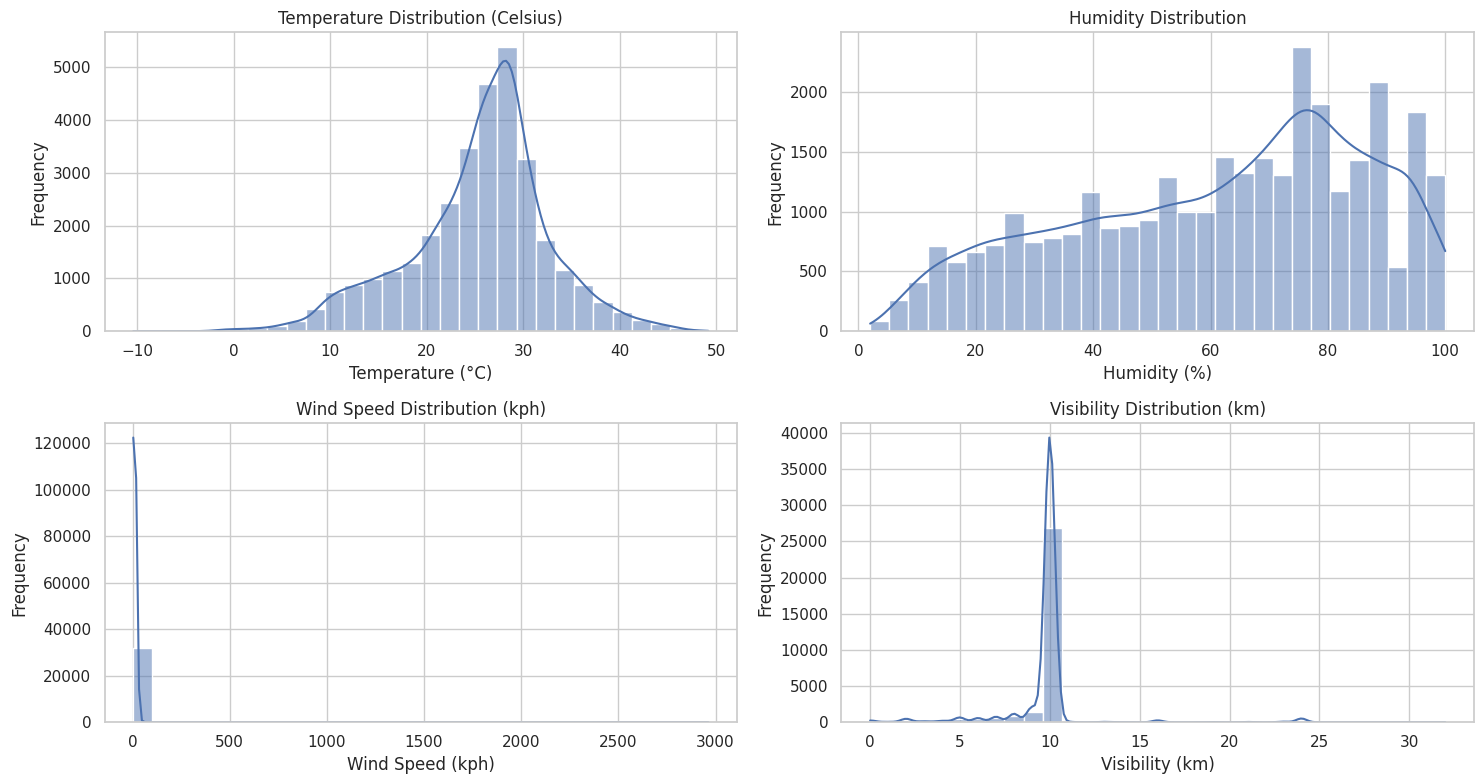

In [12]:
# Set up visualization style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Plotting temperature distribution
plt.subplot(2, 2, 1)
sns.histplot(data['temperature_celsius'], bins=30, kde=True)
plt.title('Temperature Distribution (Celsius)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

# Plotting humidity distribution
plt.subplot(2, 2, 2)
sns.histplot(data['humidity'], bins=30, kde=True)
plt.title('Humidity Distribution')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')

# Plotting wind speed distribution
plt.subplot(2, 2, 3)
sns.histplot(data['wind_kph'], bins=30, kde=True)
plt.title('Wind Speed Distribution (kph)')
plt.xlabel('Wind Speed (kph)')
plt.ylabel('Frequency')

# Plotting visibility distribution
plt.subplot(2, 2, 4)
sns.histplot(data['visibility_km'], bins=30, kde=True)
plt.title('Visibility Distribution (km)')
plt.xlabel('Visibility (km)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



This report highlights key patterns in global weather data:

1. **Temperature**: Most values range between **20–30°C**, with rare extremes below 0°C or above 40°C.  
2. **Humidity**: High levels dominate, peaking around **80%**, with lower humidity being uncommon.  
3. **Wind Speed**: Generally low, below **50 kph**, with rare spikes indicating extreme weather events.  
4. **Visibility**: Predominantly good, at **10–15 km**, with occasional poor visibility due to specific conditions.

In simple terms, weather patterns are largely moderate, with infrequent extreme conditions requiring attention for improved forecasting and disaster preparedness.

# Correlation Heatmap #

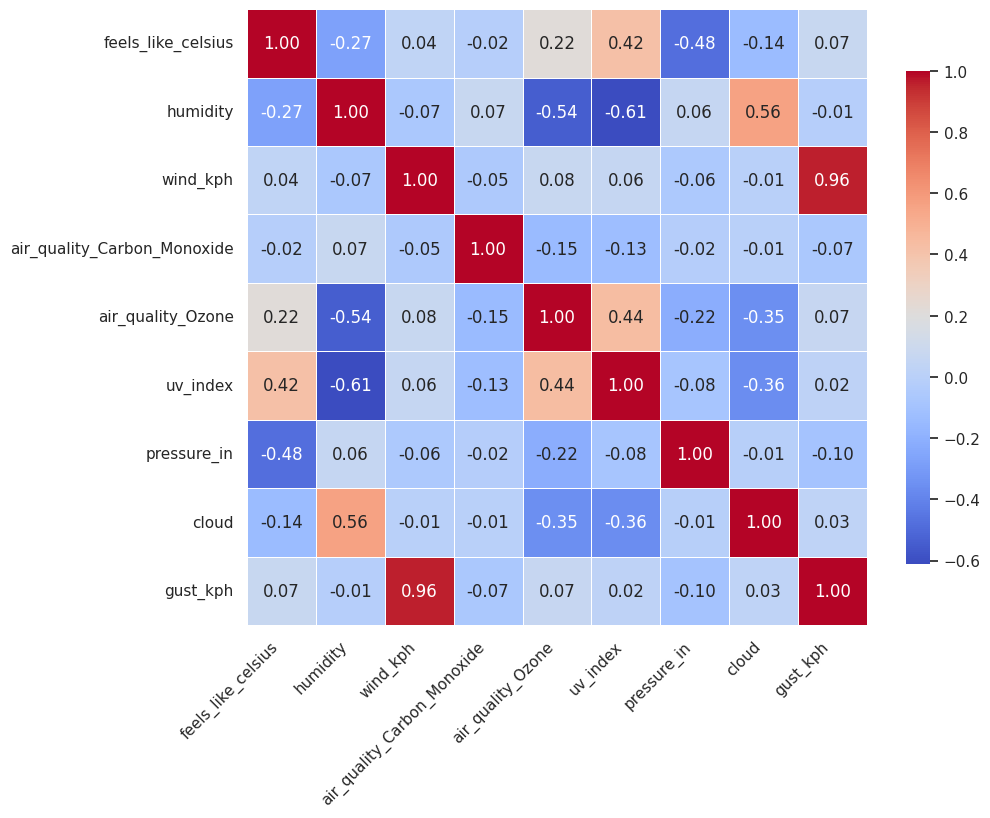

In [13]:
# Create a new DataFrame with only the important_features
data_subset = data[important_features]

# Calculate the correlation matrix for the selected subset ONLY
corr_matrix_subset = data_subset.corr()

# Plot the heatmap for the subset
plt.figure(figsize=(10, 8))  # Adjust the figure size to fit the subset
sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, cbar_kws={"shrink": .8})  # `linewidths` adds space between cells
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

* The heatmap shows correlations between weather and air quality variables. Strong positive correlations include temperature and "feels like" temperature (0.96), as well as wind speed and gust speed (0.96), meaning these pairs of variables move together. There’s a notable negative correlation between humidity and UV index (-0.61), showing that higher humidity tends to reduce UV exposure, likely due to cloud cover. Humidity also correlates with more cloud cover (0.56) and lower ozone levels (-0.54). Overall, the heatmap highlights how variables like temperature, wind, humidity, and air quality interact, providing insight into how changes in one can predict shifts in others.

## Step 4: ##

# Split data #

In [32]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 5: ##

 # Define models #


In [15]:
# Ensemble Model Pipeline with reduced estimators for speed
ensemble_models = {
    "RandomForest": RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=50, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=42)
}

## Step 6: ##

#Hyperparameter tuning for the models#

In [16]:
# Hyperparameter tuning using RandomizedSearchCV (for RandomForest and GradientBoosting)
rfc_params = {
    "regressor__n_estimators": [50, 100],
    "regressor__max_depth": [10, 20],
    "regressor__min_samples_split": [2, 5]
}

gbc_params = {
    "regressor__n_estimators": [50, 100],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [3, 5],
    "regressor__n_iter_no_change": [5]  # Early stopping
}


## Step 7: ##

# Evaluate models #


In [33]:
# Train and Evaluate Models
best_model = None
best_score = float('-inf')
best_model_name = ""
results = {}  # Initialize results dictionary

for name, model in ensemble_models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    if name == "RandomForest":
        random_search = RandomizedSearchCV(pipeline, rfc_params, n_iter=10, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
        random_search.fit(X_train, y_train)
        pipeline = random_search.best_estimator_
    elif name == "GradientBoosting":
        random_search = RandomizedSearchCV(pipeline, gbc_params, n_iter=10, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
        random_search.fit(X_train, y_train)
        pipeline = random_search.best_estimator_
    else:
        pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)  # Calculate MSE

    print(f"{name} MSE: {mse}")
    print(f"{name} R² Score: {score}")

    # Store metrics in results dictionary
    results[name] = {"MSE": mse, "R²": score}



Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForest MSE: 0.23265275939665536
RandomForest R² Score: 0.9956733995140787
Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


GradientBoosting MSE: 0.24764510396587197
GradientBoosting R² Score: 0.9953945896453864
ExtraTrees MSE: 0.20433481748633872
ExtraTrees R² Score: 0.9962000230604626


## Step 8: ##

 # Print summary of results #

In [37]:
# Summary of Results
for model_name, metrics in results.items():
    print(f"\n{model_name} Summary:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


RandomForest Summary:
MSE: 0.23265275939665536
R²: 0.9956733995140787

GradientBoosting Summary:
MSE: 0.24764510396587197
R²: 0.9953945896453864

ExtraTrees Summary:
MSE: 0.20433481748633872
R²: 0.9962000230604626


### **Interpretation of Results**  

In evaluating the performance of the ensemble models, the following insights were observed:  

#### **Random Forest Model**  
- **Mean Squared Error (MSE):** 0.2327  
- **R-squared (R²):** 0.9957  

The Random Forest model demonstrates strong predictive accuracy with an R² score of 99.57%, indicating that it explains most of the variance in the target variable. The low MSE confirms that its predictions are close to the actual values.  

#### **Gradient Boosting Model**  
- **Mean Squared Error (MSE):** 0.2476  
- **R-squared (R²):** 0.9954  

The Gradient Boosting model also performs exceptionally well, with an R² score of 99.54%, meaning it effectively captures the underlying patterns in the data. While its MSE is slightly higher than the Random Forest model, it remains highly competitive.  

#### **Extra Trees Model (Best Performing Model)**  
- **Mean Squared Error (MSE):** 0.2043  
- **R-squared (R²):** 0.9962  

Among the three models, the Extra Trees model achieved the best performance, with the highest R² score (99.62%) and the lowest MSE (0.2043). This suggests that it makes the most accurate predictions while maintaining robustness.  

All three models provide excellent predictions, but the **Extra Trees model is the best choice** due to its superior R² score and lowest MSE. This model effectively minimizes errors and generalizes well to unseen data, making it the most reliable for temperature prediction.

## Step 9: ##

 # Save each model  #

In [34]:
# Save each model
joblib.dump(pipeline, f"weather_model_{name}.pkl")


['weather_model_ExtraTrees.pkl']

## Step 10: ##

 # Update best model #

In [38]:
# Update best model
if score > best_score:
        best_score = score
        best_model = pipeline
        best_model_name = name


## Step 11: ##

 #  Save the best model  #

In [39]:
# Save the best model as best_extratrees_model.pkl
if best_model:
    joblib.dump(best_model, "best_extratrees_model.pkl")
print(f"Best model ({best_model_name}) saved as 'best_{best_model_name.lower().replace(' ', '_')}_model.pkl'")

Best model (ExtraTrees) saved as 'best_extratrees_model.pkl'


#Step 12: #

# Evaluate the Best Model on Test Data #



Test Performance:
Mean Squared Error (MSE): 0.2043
Mean Absolute Error (MAE): 0.2592
R-squared (R²): 0.9962


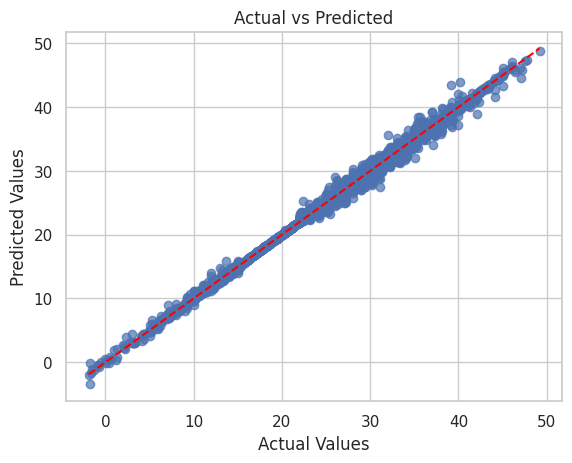

In [40]:
# Load and Evaluate the Best Model
best_pipeline = joblib.load("best_extratrees_model.pkl")
y_pred = best_pipeline.predict(X_test)

# Evaluate Performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot Predicted vs Actual Values
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


### **Test Performance Interpretation**  

The model performed exceptionally well on the test data:  

#### **Strong Correlation:**  
The high **R-squared (R²) score of 0.9962** indicates that the model explains **99.62%** of the variance in the target variable. This means the model captures the underlying patterns in the data very effectively, leading to highly accurate predictions.  

#### **Minimal Error:**  
- **Mean Squared Error (MSE):** 0.2043  
- **Mean Absolute Error (MAE):** 0.2592  

These low error values suggest that the model's predictions are very close to the actual values. The **MAE of 0.2592** indicates that, on average, the model’s predictions deviate by only about 0.26 from the true values.  

In simple terms, the model is highly reliable for temperature prediction, with minimal errors and a strong correlation between predicted and actual values. The numerical metrics confirm that it makes precise and consistent predictions, making it an excellent choice for real-world applications.